In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [3]:
tf.random.set_seed(47)
np.random.seed(47)

In [4]:
# !pip install optuna > /dev/null

In [5]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [6]:
plt.rcParams['figure.figsize'] = (16,6)

In [7]:
df = pd.read_csv('../input/stockdata/ADBL_data.csv')
df['Date'] = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Open,High,Low,Close
0,2012-01-01,115.0,115.0,113.0,114.0
1,2012-01-02,114.0,118.0,115.0,118.0
2,2012-01-03,118.0,116.0,114.0,115.0
3,2012-01-04,115.0,115.0,113.0,114.0
4,2012-01-05,114.0,114.0,112.0,113.0


Using only Date and Close

In [9]:
df = df[['Date', 'Close']]

In [10]:
df.describe()

,Close
count,1911.00000
mean,406.92831
std,167.13069
min,101.00000
25%,313.00000
50%,420.00000
75%,480.00000
max,1082.00000


In [11]:
df.head()

,Date,Close
0,2012-01-01,114.0
1,2012-01-02,118.0
2,2012-01-03,115.0
3,2012-01-04,114.0
4,2012-01-05,113.0


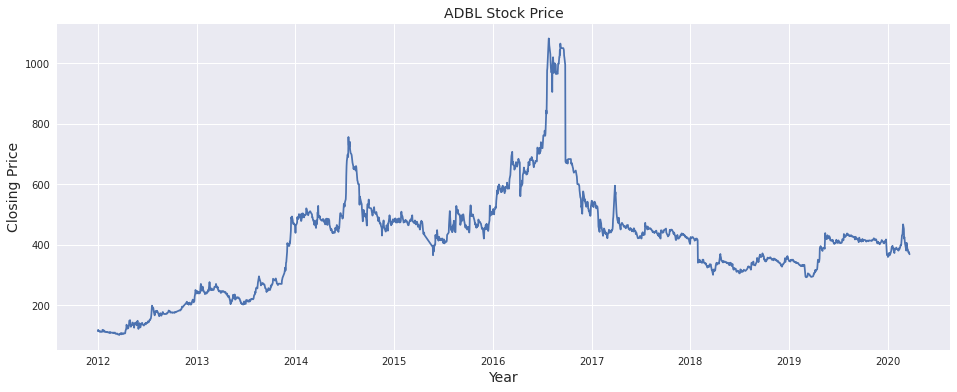

In [12]:
plt.title('ADBL Stock Price', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.plot(df['Date'], df['Close'])
plt.show()

# Generating features from target variable

In [13]:
# Percentage change is : (Todays price - yesterdays price) / yesterdays price
# For instance: (658.0 - 661.0) / 661.0
df['returns'] = df.Close.pct_change() * 100

In [14]:
# Generate Simple moving averages over the period of 10, 15, 20 and 30 days
for period in [10, 15, 20, 30]:
    column = f'sma_{period}'
    df[column] = df[['Close']].rolling(period).mean()

In [15]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
df.head()

,Date,Close,returns,sma_10,sma_15,sma_20,sma_30
0,2012-02-14,109.0,0.925926,109.8,110.533333,111.70,112.300000
1,2012-02-15,111.0,1.834862,109.8,110.466667,111.70,112.200000
2,2012-02-16,108.0,-2.702703,109.5,110.066667,111.45,111.866667
3,2012-02-21,109.0,0.925926,109.4,109.866667,111.00,111.666667
4,2012-02-23,109.0,0.000000,109.2,109.666667,110.60,111.500000


In [17]:
data = df[['Close', 'returns', 'sma_10', 'sma_15', 'sma_20', 'sma_30']].values
data

array([[109.        ,   0.92592593, 109.8       , 110.53333333,
        111.7       , 112.3       ],
       [111.        ,   1.83486239, 109.8       , 110.46666667,
        111.7       , 112.2       ],
       [108.        ,  -2.7027027 , 109.5       , 110.06666667,
        111.45      , 111.86666667],
       ...,
       [374.        ,  -1.05820106, 394.5       , 411.46666667,
        411.4       , 402.93333333],
       [376.        ,   0.53475936, 389.6       , 407.53333333,
        410.3       , 402.6       ],
       [368.        ,  -2.12765957, 384.8       , 401.86666667,
        408.85      , 402.03333333]])

# Train, validation and test split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_data = train_test_split(data, test_size=0.20, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(1505, 6)
(188, 6)
(189, 6)


# Scaling input data

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Generating input features based on time step

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)


Train Samples: 1504
Validation Samples: 187
Test Samples: 188


# Scaling back output data to original Closing price

In [24]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [25]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(1504,) (187,) (188,)


In [26]:
x_train[1], y_train[0]

(array([[0.01019368, 0.80633345, 0.00657965, 0.00666619, 0.00774475,
         0.00736974]]),
 0.010193679918450563)

In [27]:
x_val[1], y_val[0]

(array([[0.25993884, 0.84555257, 0.25002653, 0.25180991, 0.25066812,
         0.24828654]]),
 0.25993883792048933)

In [28]:
x_test[1], y_test[0]

(array([[0.3088685 , 0.72241604, 0.33057413, 0.33761021, 0.34278702,
         0.33746039]]),
 0.308868501529052)

# LSTM Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from tensorflow.keras import optimizers

## Hyperparameter Search

In [30]:
early_stopping_rounds = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)

In [31]:
# Objective function
def run(trial):
    space = {
        'optimizer':  trial.suggest_categorical('optimizer', [optimizers.Adam, optimizers.Adagrad, optimizers.Adamax, optimizers.Nadam, optimizers.RMSprop, optimizers.SGD]),
        'units_1': trial.suggest_int('units_1', 50, 4000, 50),
        'dropout_rate_1': trial.suggest_float('dropout_rate_1', 0.1, 0.6),
        'units_2': trial.suggest_int('units_2', 50, 4000, 50),
        'dropout_rate_2': trial.suggest_float('dropout_rate_2', 0.1, 0.6),
        'units_3': trial.suggest_int('units_3', 50, 4000, 50),
        'dropout_rate_3': trial.suggest_float('dropout_rate_3', 0.1, 0.6),
        'units_4': trial.suggest_int('units_4', 50, 4000, 50),
        'dropout_rate_4': trial.suggest_float('dropout_rate_4', 0.1, 0.6),
        'epochs': trial.suggest_int('epochs', 100, 5000, 50),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256, 512]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 8e-1)
    }

    model = Sequential()
    # Adding the first LSTM layer and some Dropout regularization
    model.add(LSTM(units=space['units_1'], return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(rate=space['dropout_rate_1']))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=space['units_2'], return_sequences = True))
    model.add(Dropout(rate=space['dropout_rate_2']))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=space['units_3'], return_sequences = True))
    model.add(Dropout(rate=space['dropout_rate_3']))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=space['units_4']))
    model.add(Dropout(rate=space['dropout_rate_4']))
    # Adding the output layer
    model.add(Dense(1))

    # Compiling the RNN
    model.compile(loss='mean_squared_error', optimizer=space['optimizer'](learning_rate=space['learning_rate']), metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=space['epochs'], validation_data=(x_val, y_val), batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_train = np.squeeze(model.predict(x_train))
    yhat_val = np.squeeze(model.predict(x_val))

    yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
    yhat_val = scaler.inverse_transform(prep_data_transform(yhat_val, X_val.shape[1]))[:,0]

    nan_check = [np.isnan(yhat_train).any(), np.isnan(yhat_val).any()]
    print(nan_check)
    if True in nan_check:
        rmse = 99999
    else:
        rmse = mean_squared_error(Y_val, yhat_val, squared=False)
    return rmse

In [32]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=30)

[I 2021-11-03 09:54:04,633] A new study created in memory with name: no-name-47dfbf77-76cd-484e-b3b9-87412f883a9f
2021-11-03 09:54:04.709007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 09:54:04.797896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 09:54:04.798706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 09:54:04.801047: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critica

[False, False]


[I 2021-11-03 10:25:33,448] Trial 1 finished with value: 36.003930533143965 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units_1': 1550, 'dropout_rate_1': 0.44378918621486185, 'units_2': 1300, 'dropout_rate_2': 0.3585921324258864, 'units_3': 2350, 'dropout_rate_3': 0.23155898580461295, 'units_4': 3200, 'dropout_rate_4': 0.19132734885627142, 'epochs': 4950, 'batch_size': 32, 'learning_rate': 0.0054236788180100515}. Best is trial 0 with value: 12.159953479224361.


[False, False]


[I 2021-11-03 10:45:06,143] Trial 2 finished with value: 8.001553271314823 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 2550, 'dropout_rate_1': 0.3803754952808779, 'units_2': 1600, 'dropout_rate_2': 0.14220476808584478, 'units_3': 600, 'dropout_rate_3': 0.21951247039152735, 'units_4': 3500, 'dropout_rate_4': 0.2608675316674042, 'epochs': 4200, 'batch_size': 32, 'learning_rate': 0.0022901074325370574}. Best is trial 2 with value: 8.001553271314823.


[False, False]


[I 2021-11-03 10:51:56,220] Trial 3 finished with value: 938.4470215470993 and parameters: {'optimizer': <class 'keras.optimizer_v2.adamax.Adamax'>, 'units_1': 450, 'dropout_rate_1': 0.5751130368585141, 'units_2': 3150, 'dropout_rate_2': 0.30169186769665146, 'units_3': 3750, 'dropout_rate_3': 0.11350206097565338, 'units_4': 1650, 'dropout_rate_4': 0.5449254151041768, 'epochs': 1350, 'batch_size': 128, 'learning_rate': 0.08273258740989292}. Best is trial 2 with value: 8.001553271314823.


[False, False]


[I 2021-11-03 11:00:47,029] Trial 4 finished with value: 15.602328387875618 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 2750, 'dropout_rate_1': 0.538624085698843, 'units_2': 2850, 'dropout_rate_2': 0.10347563729812356, 'units_3': 3100, 'dropout_rate_3': 0.17024317964338495, 'units_4': 2750, 'dropout_rate_4': 0.5365417009668867, 'epochs': 3400, 'batch_size': 512, 'learning_rate': 0.0032332260019939324}. Best is trial 2 with value: 8.001553271314823.


[False, False]


[I 2021-11-03 11:06:27,645] Trial 5 finished with value: 16.636415951711946 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units_1': 1600, 'dropout_rate_1': 0.49716214535816805, 'units_2': 2650, 'dropout_rate_2': 0.27442660016422693, 'units_3': 2700, 'dropout_rate_3': 0.38252116022056804, 'units_4': 3350, 'dropout_rate_4': 0.32623172083506635, 'epochs': 650, 'batch_size': 512, 'learning_rate': 0.2789445663994662}. Best is trial 2 with value: 8.001553271314823.


[False, False]


[I 2021-11-03 11:25:14,701] Trial 6 finished with value: 81.00086092830546 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units_1': 850, 'dropout_rate_1': 0.1676300047177949, 'units_2': 1150, 'dropout_rate_2': 0.11722460675446647, 'units_3': 2150, 'dropout_rate_3': 0.2804716884486299, 'units_4': 2050, 'dropout_rate_4': 0.4621364751546777, 'epochs': 600, 'batch_size': 16, 'learning_rate': 0.012552240328116429}. Best is trial 2 with value: 8.001553271314823.


[False, False]


[I 2021-11-03 11:41:06,696] Trial 7 finished with value: 13.315636921123776 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units_1': 2300, 'dropout_rate_1': 0.11205778703459976, 'units_2': 800, 'dropout_rate_2': 0.2627093585638942, 'units_3': 600, 'dropout_rate_3': 0.5902915507534637, 'units_4': 2250, 'dropout_rate_4': 0.5746603103632643, 'epochs': 4500, 'batch_size': 128, 'learning_rate': 0.07287232241347691}. Best is trial 2 with value: 8.001553271314823.


[False, False]


[I 2021-11-03 11:44:52,594] Trial 8 finished with value: 40610.37050695348 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 3200, 'dropout_rate_1': 0.1704142488669407, 'units_2': 250, 'dropout_rate_2': 0.4719379572355554, 'units_3': 2200, 'dropout_rate_3': 0.5867638529368862, 'units_4': 3150, 'dropout_rate_4': 0.5746679755552534, 'epochs': 2100, 'batch_size': 128, 'learning_rate': 0.06776602368088806}. Best is trial 2 with value: 8.001553271314823.


[False, False]


[I 2021-11-03 11:48:04,688] Trial 9 finished with value: 77.7777653831693 and parameters: {'optimizer': <class 'keras.optimizer_v2.gradient_descent.SGD'>, 'units_1': 1900, 'dropout_rate_1': 0.10766652876681501, 'units_2': 1950, 'dropout_rate_2': 0.1779605039256195, 'units_3': 350, 'dropout_rate_3': 0.29333498611418873, 'units_4': 3350, 'dropout_rate_4': 0.38496212223667825, 'epochs': 4600, 'batch_size': 512, 'learning_rate': 0.008098153756510977}. Best is trial 2 with value: 8.001553271314823.


[False, False]


[I 2021-11-03 12:07:15,544] Trial 10 finished with value: 7.2427717280845885 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3500, 'dropout_rate_1': 0.3291439724075297, 'units_2': 1900, 'dropout_rate_2': 0.2013243586877971, 'units_3': 1200, 'dropout_rate_3': 0.4254465135024432, 'units_4': 450, 'dropout_rate_4': 0.10581385446613562, 'epochs': 3600, 'batch_size': 32, 'learning_rate': 0.001199461821755222}. Best is trial 10 with value: 7.2427717280845885.


[False, False]


[I 2021-11-03 12:21:44,965] Trial 11 finished with value: 7.722292973847243 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3450, 'dropout_rate_1': 0.33895463207487125, 'units_2': 1900, 'dropout_rate_2': 0.197964505166997, 'units_3': 1100, 'dropout_rate_3': 0.43011605513963036, 'units_4': 150, 'dropout_rate_4': 0.1306910904482553, 'epochs': 3600, 'batch_size': 32, 'learning_rate': 0.001073080171621721}. Best is trial 10 with value: 7.2427717280845885.


[False, False]


[I 2021-11-03 12:52:28,115] Trial 12 finished with value: 8.700598515823296 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3950, 'dropout_rate_1': 0.2865509600988867, 'units_2': 2300, 'dropout_rate_2': 0.5773239928568061, 'units_3': 1250, 'dropout_rate_3': 0.44134276062226746, 'units_4': 50, 'dropout_rate_4': 0.10334315171107628, 'epochs': 3600, 'batch_size': 32, 'learning_rate': 0.0010901170994612453}. Best is trial 10 with value: 7.2427717280845885.


[False, False]


[I 2021-11-03 13:06:02,787] Trial 13 finished with value: 6.90360197464568 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 4000, 'dropout_rate_1': 0.269282256651825, 'units_2': 1950, 'dropout_rate_2': 0.21093903525553034, 'units_3': 1400, 'dropout_rate_3': 0.467895848180233, 'units_4': 50, 'dropout_rate_4': 0.10610654584341837, 'epochs': 2450, 'batch_size': 64, 'learning_rate': 0.001448683017678343}. Best is trial 13 with value: 6.90360197464568.


[False, False]


[I 2021-11-03 13:12:40,300] Trial 14 finished with value: 52.81858857250578 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 4000, 'dropout_rate_1': 0.2676553915278958, 'units_2': 3450, 'dropout_rate_2': 0.2258017244195034, 'units_3': 1450, 'dropout_rate_3': 0.5006658746233656, 'units_4': 800, 'dropout_rate_4': 0.20255189110757732, 'epochs': 2250, 'batch_size': 64, 'learning_rate': 0.027419439686157558}. Best is trial 13 with value: 6.90360197464568.


[False, False]


[I 2021-11-03 13:16:45,935] Trial 15 finished with value: 11843.75650841455 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3350, 'dropout_rate_1': 0.2353525811662478, 'units_2': 650, 'dropout_rate_2': 0.36563228958521327, 'units_3': 1600, 'dropout_rate_3': 0.5079658202177714, 'units_4': 950, 'dropout_rate_4': 0.17526953248438007, 'epochs': 2500, 'batch_size': 64, 'learning_rate': 0.7550699180957993}. Best is trial 13 with value: 6.90360197464568.


[False, False]


[I 2021-11-03 13:20:10,030] Trial 16 finished with value: 8.215128184559802 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3650, 'dropout_rate_1': 0.41298429699896105, 'units_2': 2400, 'dropout_rate_2': 0.22386334165555202, 'units_3': 950, 'dropout_rate_3': 0.3602366577453303, 'units_4': 750, 'dropout_rate_4': 0.2651286770821856, 'epochs': 1600, 'batch_size': 256, 'learning_rate': 0.0024687543147699563}. Best is trial 13 with value: 6.90360197464568.


[False, False]


[I 2021-11-03 13:43:38,195] Trial 17 finished with value: 13.469746356499298 and parameters: {'optimizer': <class 'keras.optimizer_v2.adagrad.Adagrad'>, 'units_1': 2900, 'dropout_rate_1': 0.23917283395770214, 'units_2': 1700, 'dropout_rate_2': 0.31668944990440395, 'units_3': 1700, 'dropout_rate_3': 0.4902972254539153, 'units_4': 1450, 'dropout_rate_4': 0.2759582248589256, 'epochs': 2850, 'batch_size': 64, 'learning_rate': 0.01811365694910564}. Best is trial 13 with value: 6.90360197464568.


[False, False]


[I 2021-11-03 14:43:34,083] Trial 18 finished with value: 7.970999288611399 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units_1': 3050, 'dropout_rate_1': 0.46400706900967426, 'units_2': 1300, 'dropout_rate_2': 0.17066919288880153, 'units_3': 100, 'dropout_rate_3': 0.4138584883567987, 'units_4': 400, 'dropout_rate_4': 0.13575806033023954, 'epochs': 4050, 'batch_size': 16, 'learning_rate': 0.0011013399223018872}. Best is trial 13 with value: 6.90360197464568.


[False, False]


[I 2021-11-03 14:48:55,385] Trial 19 finished with value: 9.238499290186073 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3600, 'dropout_rate_1': 0.3048817528618476, 'units_2': 2200, 'dropout_rate_2': 0.4296270412443903, 'units_3': 1800, 'dropout_rate_3': 0.31913534032141466, 'units_4': 1300, 'dropout_rate_4': 0.21834040948309918, 'epochs': 1650, 'batch_size': 256, 'learning_rate': 0.002452932526431024}. Best is trial 13 with value: 6.90360197464568.


[False, False]


[I 2021-11-03 14:57:33,143] Trial 20 finished with value: 95.1638871179602 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3850, 'dropout_rate_1': 0.37830533283410156, 'units_2': 2750, 'dropout_rate_2': 0.2566304397616821, 'units_3': 1050, 'dropout_rate_3': 0.5384401205520543, 'units_4': 500, 'dropout_rate_4': 0.10066855813732925, 'epochs': 3000, 'batch_size': 64, 'learning_rate': 0.004972615227709787}. Best is trial 13 with value: 6.90360197464568.


[False, False]


[I 2021-11-03 15:14:13,646] Trial 21 finished with value: 6.468892852327199 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3350, 'dropout_rate_1': 0.34030472644732973, 'units_2': 1900, 'dropout_rate_2': 0.19429869453603624, 'units_3': 900, 'dropout_rate_3': 0.4370862348253905, 'units_4': 200, 'dropout_rate_4': 0.15995133263816325, 'epochs': 3650, 'batch_size': 32, 'learning_rate': 0.0010462584173215076}. Best is trial 21 with value: 6.468892852327199.


[False, False]


[I 2021-11-03 15:37:56,959] Trial 22 finished with value: 6.352539492995479 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 3250, 'dropout_rate_1': 0.21608813857287912, 'units_2': 1600, 'dropout_rate_2': 0.1510045098464507, 'units_3': 750, 'dropout_rate_3': 0.4573491414587825, 'units_4': 400, 'dropout_rate_4': 0.16018688493100539, 'epochs': 3800, 'batch_size': 32, 'learning_rate': 0.0017163753323878738}. Best is trial 22 with value: 6.352539492995479.


[False, False]


[I 2021-11-03 15:49:42,852] Trial 23 finished with value: 6.5855169330960965 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 2400, 'dropout_rate_1': 0.19287389270685695, 'units_2': 1600, 'dropout_rate_2': 0.1546099010289933, 'units_3': 750, 'dropout_rate_3': 0.46681807792109703, 'units_4': 50, 'dropout_rate_4': 0.1717599457742047, 'epochs': 4050, 'batch_size': 32, 'learning_rate': 0.001910569955201124}. Best is trial 22 with value: 6.352539492995479.


[False, False]


[I 2021-11-03 16:03:00,142] Trial 24 finished with value: 6.444783103887337 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 2250, 'dropout_rate_1': 0.2075511407615358, 'units_2': 900, 'dropout_rate_2': 0.1350925212285677, 'units_3': 700, 'dropout_rate_3': 0.5495346439510791, 'units_4': 1100, 'dropout_rate_4': 0.1573887490641785, 'epochs': 4150, 'batch_size': 32, 'learning_rate': 0.002038119643697631}. Best is trial 22 with value: 6.352539492995479.


[False, False]


[I 2021-11-03 16:13:31,683] Trial 25 finished with value: 54.663427891370965 and parameters: {'optimizer': <class 'keras.optimizer_v2.adam.Adam'>, 'units_1': 1100, 'dropout_rate_1': 0.21251489147984887, 'units_2': 50, 'dropout_rate_2': 0.1331920147740751, 'units_3': 50, 'dropout_rate_3': 0.5526121158659246, 'units_4': 1150, 'dropout_rate_4': 0.3138995142605894, 'epochs': 4950, 'batch_size': 32, 'learning_rate': 0.004243115441398773}. Best is trial 22 with value: 6.352539492995479.


[False, False]


[I 2021-11-03 16:34:06,531] Trial 26 finished with value: 23.891666055691868 and parameters: {'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>, 'units_1': 2650, 'dropout_rate_1': 0.15042214730494213, 'units_2': 800, 'dropout_rate_2': 0.10080321307831369, 'units_3': 450, 'dropout_rate_3': 0.5461535538169934, 'units_4': 4000, 'dropout_rate_4': 0.2290796174374252, 'epochs': 3950, 'batch_size': 32, 'learning_rate': 0.01016262707721304}. Best is trial 22 with value: 6.352539492995479.


[False, False]


[I 2021-11-03 17:13:02,281] Trial 27 finished with value: 6.440620935108079 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units_1': 2100, 'dropout_rate_1': 0.23868006185947596, 'units_2': 1050, 'dropout_rate_2': 0.16188057551344076, 'units_3': 850, 'dropout_rate_3': 0.3921048566301033, 'units_4': 1750, 'dropout_rate_4': 0.16772569369604157, 'epochs': 4450, 'batch_size': 32, 'learning_rate': 0.0018914577814647564}. Best is trial 22 with value: 6.352539492995479.


[False, False]


[I 2021-11-03 17:20:44,024] Trial 28 finished with value: 124.22053635622296 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units_1': 2000, 'dropout_rate_1': 0.2252995018129006, 'units_2': 1000, 'dropout_rate_2': 0.13710815904850457, 'units_3': 400, 'dropout_rate_3': 0.3773419291414941, 'units_4': 1650, 'dropout_rate_4': 0.14993845961277089, 'epochs': 4550, 'batch_size': 32, 'learning_rate': 0.007701414387000313}. Best is trial 22 with value: 6.352539492995479.


[False, False]


[I 2021-11-03 17:28:30,536] Trial 29 finished with value: 46.811609818872306 and parameters: {'optimizer': <class 'keras.optimizer_v2.nadam.Nadam'>, 'units_1': 1700, 'dropout_rate_1': 0.14503176378522034, 'units_2': 500, 'dropout_rate_2': 0.5750338342766612, 'units_3': 1900, 'dropout_rate_3': 0.3913978931166373, 'units_4': 2450, 'dropout_rate_4': 0.38192716666202453, 'epochs': 3300, 'batch_size': 32, 'learning_rate': 0.0038662104204782244}. Best is trial 22 with value: 6.352539492995479.


[False, False]
CPU times: user 3h 27min 28s, sys: 18min 26s, total: 3h 45min 54s
Wall time: 7h 34min 25s


In [33]:
best_params = study.best_params
best_params

{'optimizer': keras.optimizer_v2.adam.Adam,
 'units_1': 3250,
 'dropout_rate_1': 0.21608813857287912,
 'units_2': 1600,
 'dropout_rate_2': 0.1510045098464507,
 'units_3': 750,
 'dropout_rate_3': 0.4573491414587825,
 'units_4': 400,
 'dropout_rate_4': 0.16018688493100539,
 'epochs': 3800,
 'batch_size': 32,
 'learning_rate': 0.0017163753323878738}

In [34]:
# best_params = {
#     'optimizer': optimizers.Adamax, 
#     'units_1': 250, 
#     'dropout_rate_1': 0.2057312045917826, 
#     'units_2': 1100, 
#     'dropout_rate_2': 0.2169296850362921, 
#     'units_3': 2700, 
#     'dropout_rate_3': 0.17119859463177092, 
#     'units_4': 400, 
#     'dropout_rate_4': 0.11650715254215019, 
#     'epochs': 3000, 
#     'batch_size': 128, 
#     'learning_rate': 0.0011702523594321187
# }

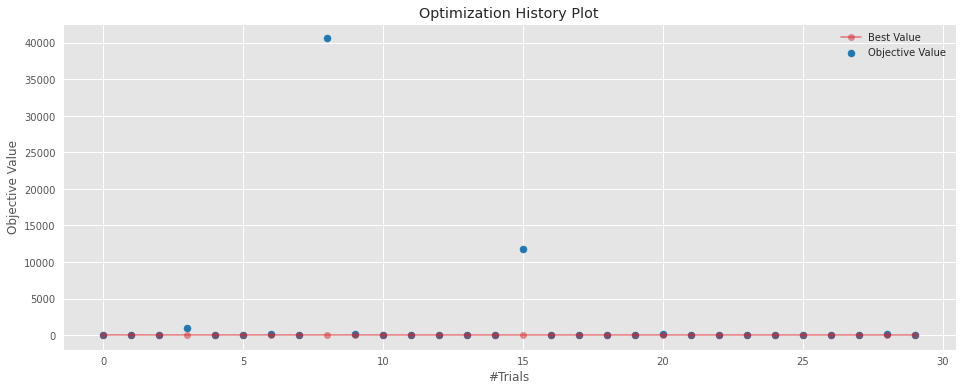

In [35]:
plot_optimization_history(study);

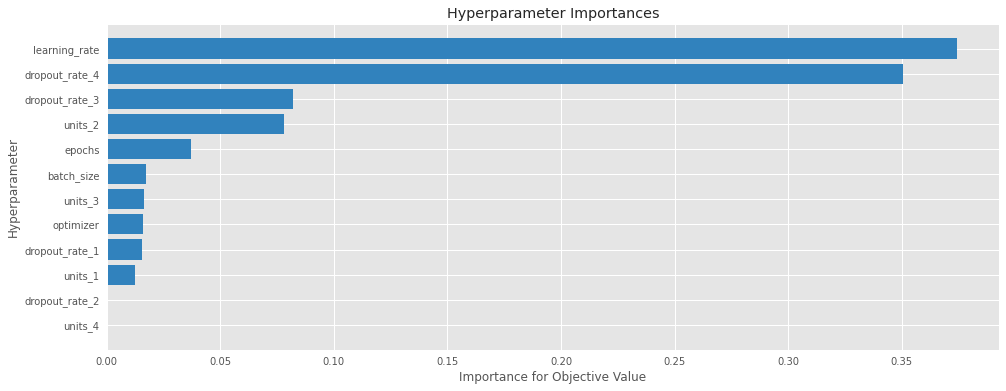

In [36]:
plot_param_importances(study);

In [37]:
optuna.visualization.plot_slice(study,params=['epochs', 'learning_rate'])

## Model Training

In [38]:
model = Sequential()
model.add(LSTM(units=best_params['units_1'], return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=best_params['dropout_rate_1']))
model.add(LSTM(units=best_params['units_2'], return_sequences=True))
model.add(Dropout(rate=best_params['dropout_rate_2']))
model.add(LSTM(units=best_params['units_3'], return_sequences=True))
model.add(Dropout(rate=best_params['dropout_rate_3']))
model.add(LSTM(units=best_params['units_4']))
model.add(Dropout(rate=best_params['dropout_rate_4']))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer=best_params['optimizer'](learning_rate=best_params['learning_rate']), metrics=['accuracy'])
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_120 (LSTM)              (None, 1, 3250)           42341000  
_________________________________________________________________
dropout_120 (Dropout)        (None, 1, 3250)           0         
_________________________________________________________________
lstm_121 (LSTM)              (None, 1, 1600)           31046400  
_________________________________________________________________
dropout_121 (Dropout)        (None, 1, 1600)           0         
_________________________________________________________________
lstm_122 (LSTM)              (None, 1, 750)            7053000   
_________________________________________________________________
dropout_122 (Dropout)        (None, 1, 750)            0         
_________________________________________________________________
lstm_123 (LSTM)              (None, 400)             

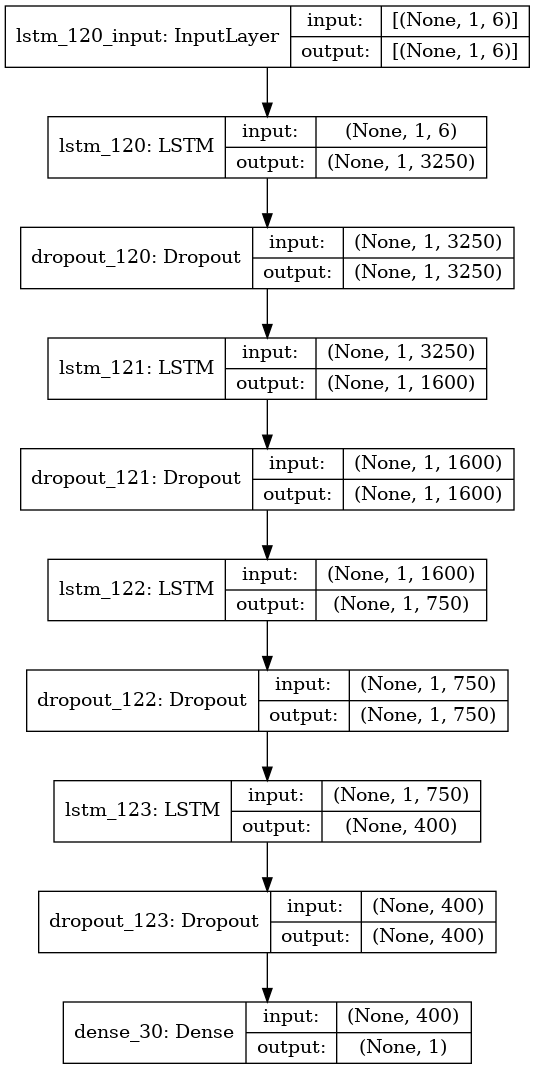

In [39]:
plot_model(model, show_shapes=True)

In [40]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 32min 52s, sys: 2min 48s, total: 35min 40s
Wall time: 1h 10min 25s


## Model Evaluation

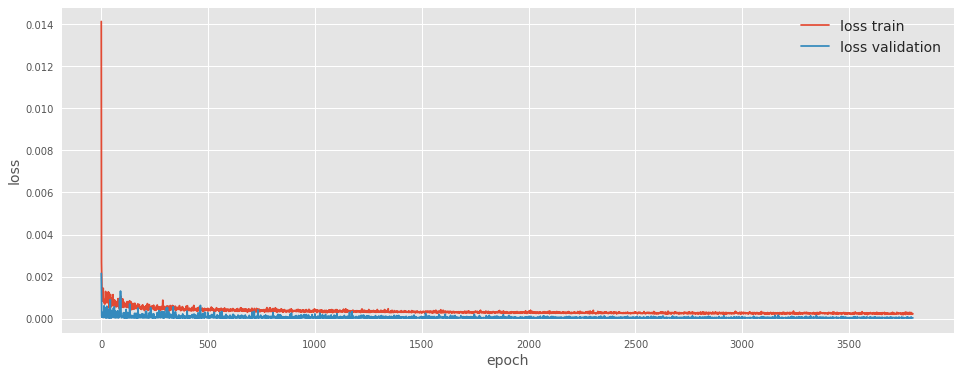

In [41]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [42]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

6/6 [==============================] - 0s 11ms/step - loss: 5.5570e-05 - accuracy: 0.0000e+00


[5.5570402764715254e-05, 0.0]

## Prediction

In [43]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

In [44]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(1504,) (188,)


In [45]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [112.29518342 113.92950943 111.11515683 112.25279111 112.00364125]
Train Actual:  [111. 108. 109. 109. 107.]
Test Predicted:  [411.62535009 404.60497832 403.91260952 402.67911014 404.70783085]
Test Actual:  [404. 403. 402. 404. 406.]


## Loss Analysis

In [46]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.65 RMSE
Test Score: 7.31 RMSE


## Plotting Predictions

In [47]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

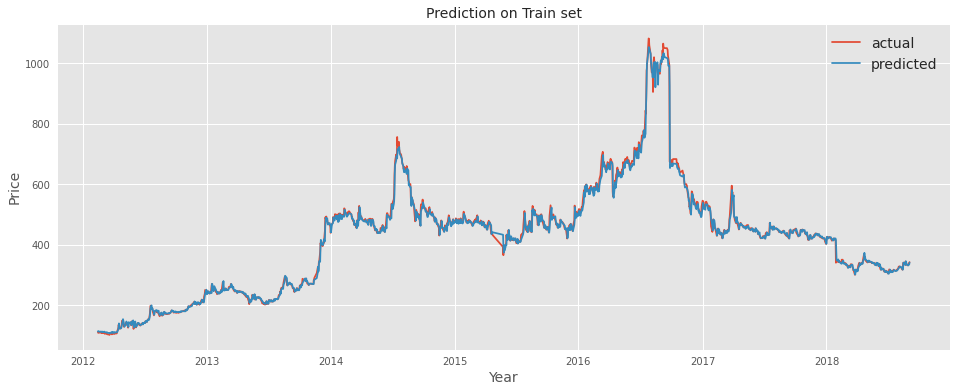

In [48]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

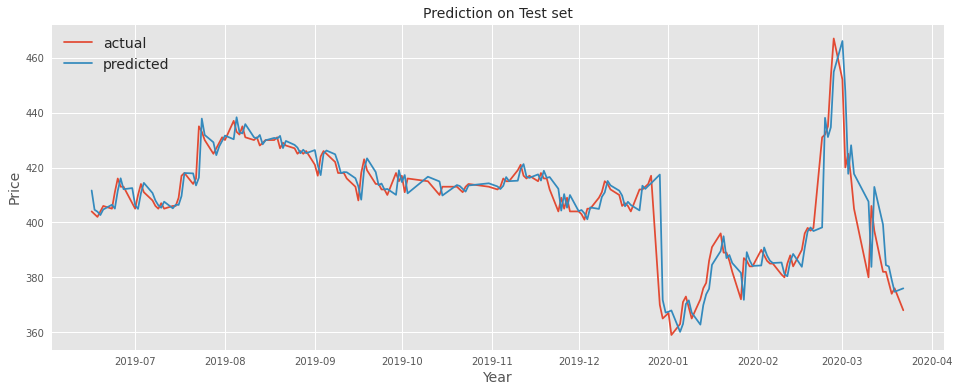

In [49]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()